# Setup

In [ ]:
%pip install tensorflow tensorboard

In [61]:
%pip install faiss-gpu

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 85.5 MB 6.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [41]:
%pip install torchattacks

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 154 kB 5.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2

# Dataloader & Dataset Visualization

In [2]:
import torch
import matplotlib.pyplot as plt

from copy import deepcopy
from torchvision import transforms
from torch.utils.data import DataLoader
from dataset import MVTecAT, Repeat, CutPasteMVTecAD
from cutpaste import CutPasteUnion, CutPaste3Way

In [3]:
class Args:
    def __init__(self) -> None:
        self.min_scale = 1
        self.size = 50
        self.cutpate_type = CutPasteUnion
        self.batch_size = 64
        self.workers = 8
        self.root_dir = '/sinergia/shabanza/datasets/mvtec'
        self.head_layer = 2
        self.data_type = 'carpet'
        self.learninig_rate = 0.03
        self.epochs = 256
        self.pretrained = True
        self.freeze_net = 20
        self.optim = 'sgd'


args = Args()

## DataLoaders

- trainloader: Returns good + cutpaste Images ([0] is image (original or cutpaste), [1] is label)
- testloader: Returns images (good or bad in real dataset) + labels (good / bad)

In [4]:
from copy import deepcopy
from typing import Tuple, List

def get_ds_transforms(args) -> List[transforms.Compose]:
    train_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.Resize((args.size, args.size))
    ])
    
    after_cutpaste_transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_cutpaste_transform = deepcopy(train_transform)
    train_cutpaste_transform.transforms.append(args.cutpate_type(transform=after_cutpaste_transform))
    train_transform.transforms.extend([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((args.size, args.size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, train_cutpaste_transform, test_transform

In [5]:
def get_dataloaders(args) -> List[DataLoader]:
    size = int(args.size * (1/args.min_scale))
    train_transform, train_cutpaste_transform, test_transform = get_ds_transforms(args)
    train_ds_normal = MVTecAT(
        args.root_dir, args.data_type, transform=train_transform, size=size, mode="train"
    )
    train_ds_anomal = CutPasteMVTecAD(
        args.root_dir, args.data_type, transform=train_cutpaste_transform, size=size, mode="train"
    )
    train_ds = torch.utils.data.ConcatDataset([train_ds_normal, train_ds_anomal])

    train_dataloader = DataLoader(
        Repeat(train_ds, 3000), batch_size=args.batch_size, drop_last=True,
        shuffle=True, num_workers=args.workers, persistent_workers=True, 
        pin_memory=True, prefetch_factor=5
    )

    train_dataloader_normal = DataLoader(
        Repeat(train_ds_normal, 3000), batch_size=args.batch_size, drop_last=True,
        shuffle=True, num_workers=args.workers, persistent_workers=True, 
        pin_memory=True, prefetch_factor=5
    )
    
    test_ds = MVTecAT(
        args.root_dir, args.data_type, args.size, transform=test_transform, mode="test"
    )
    test_dataloader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False, num_workers=0)
    
    return train_dataloader, train_dataloader_normal, test_dataloader

## Visualize

In [5]:
def visualize(sample_images, labels):
    # Convert the tensor to numpy array
    sample_images_np = sample_images.numpy()

    # Reshape the tensor to [num_samples, 256, 256, 3] for visualization
    sample_images_np = sample_images_np.transpose(0, 2, 3, 1)

    _, axes = plt.subplots(1, sample_images_np.shape[0], figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(sample_images_np[i])
        ax.set_title('anomal' if labels[i] else 'normal')
        ax.axis('off')

    plt.show()

In [ ]:
train_dataloader, train_dataloader_normal, test_dataloader = get_dataloaders(args)

In [7]:
num_samples = 5
sample_indices = torch.randperm(args.batch_size)[:num_samples]

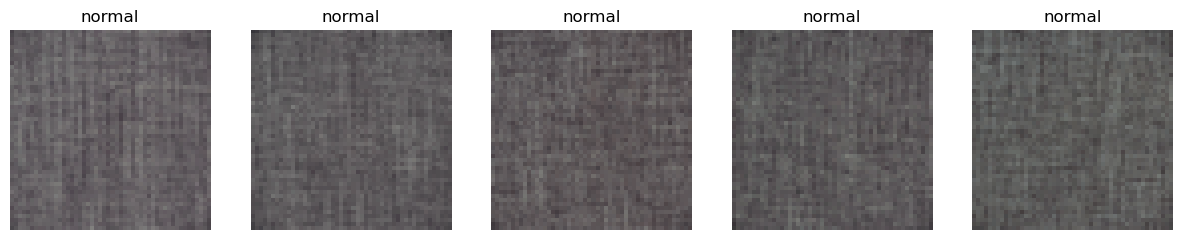

In [8]:
# visualize normal

images, labels = next(iter(train_dataloader_normal))
visualize(images[sample_indices], labels[sample_indices])

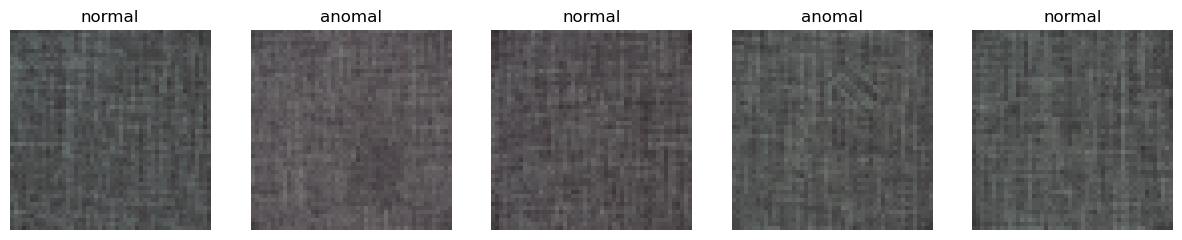

In [9]:
# visualize normal + cutpaste

images, labels = next(iter(train_dataloader))
visualize(images[sample_indices], labels[sample_indices])

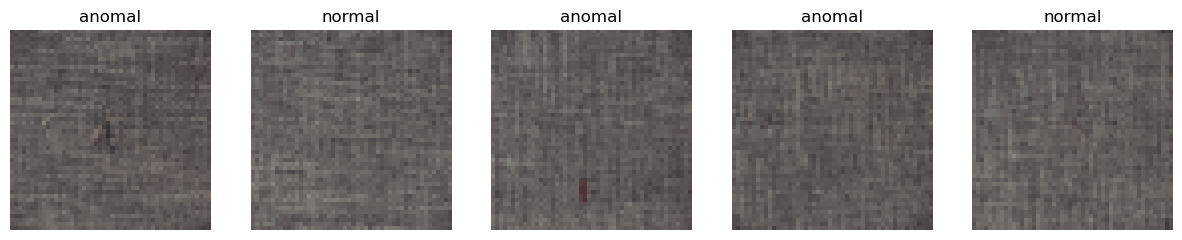

In [10]:
# visualize test

images, labels = next(iter(test_dataloader))
visualize(images[sample_indices], labels[sample_indices])

# Train

In [6]:
import sys
import datetime
import numpy as np
import torch.optim as optim
from sklearn import metrics
import time
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from model import ProjectionNet
from utils import save_checkpoint, load_checkpoint, knn_score
from attacks import LossPGDAttack, KNNPGDAttack

In [16]:
# pgd attack settings

pgd_constant = 2.5
eps = 8/255
k = 10
alpha = (pgd_constant * eps) / k

In [17]:
def train(model, loader, loss_fn, optimizer, device, attack=False):
    """ training one epoch and calculate loss and metrics """
    # Training model
    model.train()
    losses = 0.0
    steps = len(loader)
    correct = 0.0
    total = 0.0
    which_class = 1
    preds = []
    targs = []
    softmax = torch.nn.Softmax(dim=1)
    adversary = LossPGDAttack(model, eps, alpha, steps, random_start=True)
    for i, (inputs, targets) in enumerate(loader):
        inputs = inputs.to(device)
        targets = targets.to(torch.int64).to(device)
        
        if attack:
            inputs = adversary(inputs, targets)
    
        outputs, _ = model(inputs)
        
        loss = loss_fn(outputs, targets)
        losses += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Calculate metrics
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        probs = softmax(outputs).squeeze()
        preds.append(probs[:, which_class].detach().cpu())
        targs.append((targets.cpu()==which_class)*1.0)

        # report
        sys.stdout.flush()
        sys.stdout.write('\r Step: [%2d/%2d], loss: %.4f - acc: %.4f'
                          % (i, steps, targets.size(0)*losses.item()/total, 100.0*correct/total))
    sys.stdout.write ('\r')

    preds = torch.cat(preds).numpy()
    targs = torch.cat(targs).numpy()
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
    train_auc = metrics.auc(fpr, tpr)

    return train_auc, losses.item()/total, 100.0*correct/total


In [18]:
def build_model(args, device):
    head_layers = [512]*args.head_layer+[128]
    num_classes = 2 if args.cutpate_type is not CutPaste3Way else 3
    model = ProjectionNet(pretrained=args.pretrained, head_layers=head_layers, num_classes=num_classes)
    model.to(device)

    if args.freeze_net > 0 and args.pretrained:
        model.freeze_resnet()

    return model

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Evaluate

In [20]:
from sklearn.metrics import roc_auc_score


def knn_evaluate(model, test_loader, train_loader_normal, device, attack=False, adversary=None):
    """ Evaluate trained weights using calculate loss and metrics """
    model.eval ()
    softmax = torch.nn.Softmax(dim=1)
    test_feature_space = []
    test_labels = []
    train_feature_space = []
    with torch.no_grad():
        for inputs, targets in train_loader_normal:
            inputs = inputs.to(device)
            targets = targets.to(torch.int64).to(device)
            outputs, features = model(inputs)
            train_feature_space.append(features)
        
        train_feature_space = torch.cat(train_feature_space, dim=0).contiguous().cpu().numpy()
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(torch.int64).to(device)
            
            if attack:
                with torch.enable_grad():
                    inputs = adversary(inputs, train_feature_space)
                    torch.no_grad()
            
            outputs, features = model(inputs)
            test_feature_space.append(features)
            test_labels.append(targets.detach().cpu())

    test_labels = torch.cat(test_labels, dim=0).cpu().numpy()
    test_feature_space = torch.cat(test_feature_space, dim=0).contiguous().cpu().numpy()
    
    distances = knn_score(train_feature_space, test_feature_space)
    auc = roc_auc_score(test_labels, distances)
    return auc, distances, test_labels

In [21]:
def evaluate(model, loader, loss_fn, device, attack=False, adversary=None):
    """ Evaluate trained weights using calculate loss and metrics """
    model.eval()
    losses = 0.0
    steps = len(loader)
    correct = 0.0
    total = 0.0
    which_class = 1
    preds = []
    targs = []
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(torch.int64).to(device)
    
            if attack:
                with torch.enable_grad():
                    inputs = adversary(inputs, targets)
                    torch.no_grad()

            outputs, _ = model(inputs)
            loss = loss_fn(outputs, targets)
            losses += loss

            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

            probs = softmax(outputs).squeeze()
            preds.append(probs[:, which_class].detach().cpu())
            targs.append((targets.cpu()==which_class)*1.0)

    preds = torch.cat(preds).numpy()
    targs = torch.cat(targs).numpy()
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
    eval_auc = metrics.auc(fpr, tpr)

    return eval_auc, losses.item()/total, 100.0*correct/total, preds, targs

# Run

In [22]:
def fit(model, train_dl, valid_dl, train_loader_normal, loss_fn, optimizer, num_epochs, device, scheduler=None, checkpoint_path=None, robust=False):
    """ fiting model to dataloaders, saving best weights and showing results """
    losses, val_losses, accs, val_accs, auces, val_auces, val_auces_knn, val_auces_msp_knn = [], [], [], [], [], [], [], []
    best_auc = 0.0

    since = time.time()
    for epoch in range(num_epochs):
        if epoch == args.freeze_net:
            model.unfreeze()
        
        train_auc, loss, acc = train(model, train_dl, loss_fn, optimizer, device, attack=robust)
        val_auc, val_loss, val_acc, preds, targs = evaluate(model, valid_dl, loss_fn, device)
        val_auc_knn, distances, _ = knn_evaluate(model, valid_dl, train_loader_normal, device)

        out = preds + (distances / np.linalg.norm(distances))
        fpr, tpr, thresholds = metrics.roc_curve(targs, out)
        msp_knn_auc = metrics.auc(fpr, tpr)

        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        auces.append(train_auc)
        val_auces.append(val_auc)
        val_auces_knn.append(val_auc_knn)
        val_auces_msp_knn.append(msp_knn_auc)

        # learning rate scheduler
        if scheduler is not None:
            scheduler.step(val_auc)

        # save weights if improved
        if val_auc >= best_auc:
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            save_checkpoint(checkpoint, checkpoint_path)
            best_auc = val_auc

        print ('Epoch [{}/{}], loss: {:.4f} - auc: {:.4f} |\n val_loss: {:.4f} - best auc: {:.4f} - val_acc: {:.4f} - val_auc_msp: {:.4f} - val_auc_knn: {:.4f} - val_auc_knn_msp: {:.4f}'
               .format(epoch + 1, num_epochs, loss, train_auc, val_loss, best_auc, val_acc, val_auc, val_auc_knn, msp_knn_auc))

    period = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format (period // 60, period % 60))

    return dict(loss=losses, val_loss=val_losses, acc=accs, val_acc=val_accs, auces=auces, val_auces=val_auces, val_auces_knn=val_auces_knn, val_auces_msp_knn=val_auces_msp_knn)

In [23]:
def plot_metrics(val_auc_knn, val_auc, val_auc_knn_msp):
    """ ploting each of metric in one line """

    plt.plot(range(len(val_auc_knn)), val_auc_knn, 'b-', label='Val_AUC_KNN')
    plt.plot(range(len(val_auc)), val_auc, 'r-', label='Val_AUC_MSP')
    plt.plot(range(len(val_auc_knn_msp)), val_auc_knn_msp, 'g-', label='Val_AUC_KNN_MSP')
    plt.title('AUC')
    plt.legend()
    plt.show()

In [24]:
def run_fit(args, robust=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    weight_decay = 0.00003
    momentum = 0.9
    train_dataloader, train_dataloader_normal, test_dataloader = get_dataloaders(args)
    model = build_model(args, device)
    loss_fn = torch.nn.CrossEntropyLoss()
    if args.optim == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=args.learninig_rate, momentum=momentum,  weight_decay=weight_decay)
        scheduler = CosineAnnealingWarmRestarts(optimizer, args.epochs)
    elif args.optim == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.learninig_rate, weight_decay=weight_decay)
        scheduler = None
    
    checkpoint_path = f'../models/model_{args.data_type}' + '_{date:%Y-%m-%d_%H_%M_%S}.pth'.format(date=datetime.datetime.now())
    history = fit(
        model=model, 
        train_dl=train_dataloader, 
        valid_dl=test_dataloader, 
        train_loader_normal=train_dataloader_normal, 
        loss_fn=loss_fn, optimizer=optimizer, 
        num_epochs=args.epochs, device=device, 
        scheduler=scheduler,
        checkpoint_path=checkpoint_path,
        robust=robust
    )
    plot_metrics(history["val_auces_knn"], history["val_auces"], history["val_auces_msp_knn"])
    print('Max val_auces_knn: ', max(history['val_auces_knn']))
    print('Max val_auces: ', max(history['val_auces']))
    print('Max val_auces_msp_knn: ', max(history["val_auces_msp_knn"]))
    
    return model, loss_fn, checkpoint_path, train_dataloader, train_dataloader_normal, test_dataloader, history


def log_evaluate(model, test_dataloader, train_dataloader_normal, loss_fn, device, attack, loss_adversary, knn_adversary):
    val_auc, val_loss, val_acc, preds, targs = evaluate(model, test_dataloader, loss_fn, device, attack=attack, adversary=loss_adversary)
    auc, distances, test_labels = knn_evaluate(model, test_dataloader, train_dataloader_normal, device, attack=False, adversary=knn_adversary)
    out = preds + (distances / np.linalg.norm(distances))
    fpr, tpr, thresholds = metrics.roc_curve(targs, out)
    msp_knn_auc = metrics.auc(fpr, tpr)

    print('Val AUC: ', val_auc)
    print('Val ACC: ', val_acc)
    print('Val Loss: ', val_loss)
    print('Val AUC KNN: ', auc)
    print('MSP KNN AUC: ', msp_knn_auc)
    print(preds, targs)
    

def run_eval(model, loss_fn, checkpoint_path, train_dataloader_normal, test_dataloader):
    load_checkpoint(checkpoint_path, model)
    # Evaluate Standard
    print("Evaluating Standard ...")
    log_evaluate(
        model, test_dataloader, 
        train_dataloader_normal, loss_fn, device, attack=False, 
        loss_adversary=None, knn_adversary=None
    )
    
    # Evaluate PGD on Loss
    print("Evaluating PGD on Loss & KNN")
    loss_adversary = LossPGDAttack(model, eps=eps, alpha=alpha, steps=k, random_start=True)
    knn_adversary = KNNPGDAttack(model, eps=eps, alpha=alpha, steps=k, random_start=True)
    log_evaluate(
        model, test_dataloader, 
        train_dataloader_normal, loss_fn, device, attack=True, 
        loss_adversary=loss_adversary, knn_adversary=knn_adversary
    )

# Results - Train Robust

## Carpet

loading images
loaded 280 images
loading images
loaded 280 images
=> saving checkpoint: 0.8117 - acc: 21.1617

Epoch [1/50], loss: 0.0127 - auc: 0.0804 |
 val_loss: 0.0131 - best auc: 0.4181 - val_acc: 23.9316 - val_auc_msp: 0.4181 - val_auc_knn: 0.4771 - val_auc_knn_msp: 0.4763
=> saving checkpoint: 0.7783 - acc: 32.8465

Epoch [2/50], loss: 0.0122 - auc: 0.1492 |
 val_loss: 0.0128 - best auc: 0.4342 - val_acc: 23.9316 - val_auc_msp: 0.4342 - val_auc_knn: 0.4783 - val_auc_knn_msp: 0.4759
=> saving checkpoint: 0.7730 - acc: 33.7976

Epoch [3/50], loss: 0.0121 - auc: 0.1505 |
 val_loss: 0.0113 - best auc: 0.4671 - val_acc: 76.0684 - val_auc_msp: 0.4671 - val_auc_knn: 0.4326 - val_auc_knn_msp: 0.4302
Epoch [4/50], loss: 0.0120 - auc: 0.2205 |0
 val_loss: 0.0161 - best auc: 0.4671 - val_acc: 23.9316 - val_auc_msp: 0.4037 - val_auc_knn: 0.4410 - val_auc_knn_msp: 0.4226
=> saving checkpoint: 0.7914 - acc: 33.8655

Epoch [5/50], loss: 0.0124 - auc: 0.2002 |
 val_loss: 0.0102 - best auc: 0.60

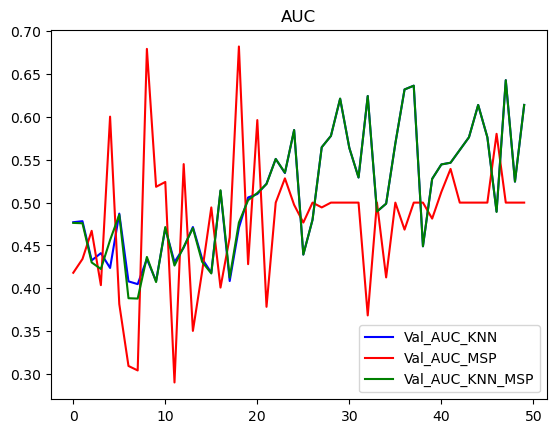

Max val_auces_knn:  0.6428571428571429
Max val_auces:  0.6821829855537721
Max val_auces_msp_knn:  0.6428571428571429


In [28]:
args.data_type = 'carpet'
args.epochs = 50
args.lr = 0.07
model, loss_fn, checkpoint_path, train_dataloader, train_dataloader_normal, test_dataloader, history = run_fit(args, robust=True)

In [29]:
checkpoint_path

'../models/model_carpet_2023-09-27_14_35_31.pth'

In [30]:
run_eval(model, loss_fn, checkpoint_path, train_dataloader_normal, test_dataloader)

=> loading checkpoint



Evaluating Standard ...
Val AUC:  0.6821829855537721
Val ACC:  76.06837606837607
Val Loss:  0.011560394213749813
Val AUC KNN:  0.4642857142857143
MSP KNN AUC:  0.4715088282504013
[0.50578123 0.5151665  0.51385593 0.5149208  0.5164582  0.5145373
 0.51353925 0.5157121  0.51693654 0.51558757 0.5188628  0.51545817
 0.51500213 0.5148893  0.51433486 0.5148356  0.5155509  0.5145495
 0.51245993 0.5155107  0.51520467 0.5160559  0.5133044  0.5152987
 0.5152753  0.51511616 0.5142573  0.5146784  0.5123829  0.51315576
 0.5143175  0.51516086 0.5150662  0.51608723 0.51556194 0.5147085
 0.513512   0.514448   0.514238   0.514494   0.51500744 0.5148789
 0.5141592  0.51565933 0.5148163  0.5059802  0.5147892  0.5146464
 0.5145623  0.5144468  0.5166766  0.5144216  0.5150874  0.51469994
 0.5133599  0.51503026 0.51353335 0.51517624 0.51508754 0.51417166
 0.5140251  0.5138125  0.5138935  0.51445997 0.51338714 0.5142924
 0.515418   0.51426953 0.51585454 0.5151982  0.5152003  0.51432747
 0.5142156  0.51626265 0

## Grid

In [32]:
args.data_type = 'grid'
args.epochs = 50
model, loss_fn, checkpoint_path, train_dataloader, train_dataloader_normal, test_dataloader, history = run_fit(args, robust=True)

loading images


loaded 264 images
loading images
loaded 264 images
=> saving checkpoint: 0.8367 - acc: 25.5774

Epoch [1/50], loss: 0.0131 - auc: 0.1131 |
 val_loss: 0.0191 - best auc: 0.5422 - val_acc: 26.9231 - val_auc_msp: 0.5422 - val_auc_knn: 0.6591 - val_auc_knn_msp: 0.6541
Epoch [2/50], loss: 0.0119 - auc: 0.0822 |2
 val_loss: 0.0180 - best auc: 0.5422 - val_acc: 28.2051 - val_auc_msp: 0.5113 - val_auc_knn: 0.6992 - val_auc_knn_msp: 0.6942
Epoch [3/50], loss: 0.0117 - auc: 0.1897 |7
 val_loss: 0.0182 - best auc: 0.5422 - val_acc: 26.9231 - val_auc_msp: 0.3333 - val_auc_knn: 0.6842 - val_auc_knn_msp: 0.6809
=> saving checkpoint: 0.8010 - acc: 29.0421

Epoch [4/50], loss: 0.0125 - auc: 0.1917 |
 val_loss: 0.0228 - best auc: 0.5681 - val_acc: 26.9231 - val_auc_msp: 0.5681 - val_auc_knn: 0.6725 - val_auc_knn_msp: 0.6792
Epoch [5/50], loss: 0.0117 - auc: 0.2590 |3
 val_loss: 0.0187 - best auc: 0.5681 - val_acc: 26.9231 - val_auc_msp: 0.4386 - val_auc_knn: 0.7310 - val_auc_knn_msp: 0.7385
Epoch [6/50

In [ ]:
checkpoint_path

In [ ]:
run_eval(model, loss_fn, checkpoint_path, train_dataloader_normal, test_dataloader)

# Results - Evaluate PGD

## Carpet

loading images


loaded 280 images
loading images
loaded 280 images
=> saving checkpoint: 0.7062 - acc: 55.6726

Epoch [1/50], loss: 0.0110 - auc: 0.5633 |
 val_loss: 0.0124 - best auc: 0.5197 - val_acc: 49.5726 - val_auc_msp: 0.5197 - val_auc_knn: 0.4005 - val_auc_knn_msp: 0.5016
=> saving checkpoint: 0.6957 - acc: 58.6617

Epoch [2/50], loss: 0.0109 - auc: 0.6086 |
 val_loss: 0.0110 - best auc: 0.6433 - val_acc: 64.1026 - val_auc_msp: 0.6433 - val_auc_knn: 0.4165 - val_auc_knn_msp: 0.6196
Epoch [3/50], loss: 0.0105 - auc: 0.6354 |3
 val_loss: 0.0105 - best auc: 0.6433 - val_acc: 68.3761 - val_auc_msp: 0.6232 - val_auc_knn: 0.4258 - val_auc_knn_msp: 0.6079
=> saving checkpoint: 0.6627 - acc: 62.9416

Epoch [4/50], loss: 0.0104 - auc: 0.6561 |
 val_loss: 0.0121 - best auc: 0.6782 - val_acc: 58.1197 - val_auc_msp: 0.6782 - val_auc_knn: 0.4310 - val_auc_knn_msp: 0.6581
Epoch [5/50], loss: 0.0104 - auc: 0.6460 |2
 val_loss: 0.0149 - best auc: 0.6782 - val_acc: 49.5726 - val_auc_msp: 0.6657 - val_auc_knn: 

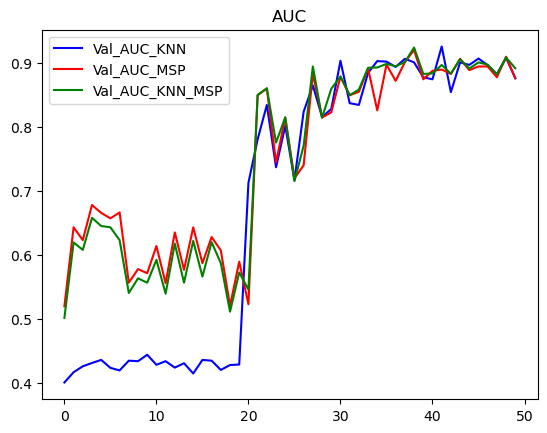

Max val_auces_knn:  0.9261637239165329
Max val_auces:  0.920545746388443
Max val_auces_msp_knn:  0.9245585874799357


In [14]:
args.data_type = 'carpet'
args.epochs = 50
model, loss_fn, checkpoint_path, train_dataloader, train_dataloader_normal, test_dataloader, history = run_fit(args)

In [16]:
run_eval(model, loss_fn, checkpoint_path, train_dataloader_normal, test_dataloader)

=> loading checkpoint



Evaluating Standard ...
Val AUC:  0.920545746388443
Val ACC:  77.77777777777777
Val Loss:  0.012634064397241315
Val AUC KNN:  0.9056982343499197
MSP KNN AUC:  0.9245585874799357
[1.         1.         0.9999931  0.9999994  0.99999976 0.9999887
 1.         1.         1.         1.         1.         0.9891951
 0.99872404 0.988602   0.9998317  0.99973327 0.9999664  0.9999993
 0.9990075  1.         0.99999845 0.9998963  0.9996948  0.9995633
 0.99916506 0.9998808  0.9998919  0.999887   0.99987686 0.9996278
 0.9999578  1.         0.99986434 0.99995136 0.999954   0.9992735
 0.9926642  0.6710267  0.729049   0.6495672  0.9965576  0.9956649
 0.99123365 0.96254927 0.9669007  0.9969311  0.99889886 0.9779605
 0.95307404 0.3777712  0.5100183  0.99960047 0.61789626 0.8588503
 0.5184522  0.09075532 0.989626   0.9984149  0.5656353  0.95504606
 0.93531036 0.9618128  0.9958494  0.94904697 0.9982962  0.9600235
 0.99963796 0.9987436  0.9982881  0.99999964 0.9999527  0.99990356
 1.         0.99964714 0.999

## Grid

loading images


loaded 264 images
loading images
loaded 264 images
=> saving checkpoint: 0.6105 - acc: 69.9389

Epoch [1/50], loss: 0.0095 - auc: 0.7589 |
 val_loss: 0.0119 - best auc: 0.7619 - val_acc: 71.7949 - val_auc_msp: 0.7619 - val_auc_knn: 0.6207 - val_auc_knn_msp: 0.7761
=> saving checkpoint: 0.4296 - acc: 80.5367

Epoch [2/50], loss: 0.0067 - auc: 0.8797 |
 val_loss: 0.0125 - best auc: 0.8613 - val_acc: 73.0769 - val_auc_msp: 0.8613 - val_auc_knn: 0.5622 - val_auc_knn_msp: 0.8546
Epoch [3/50], loss: 0.0068 - auc: 0.8716 |6
 val_loss: 0.0083 - best auc: 0.8613 - val_acc: 78.2051 - val_auc_msp: 0.8396 - val_auc_knn: 0.5439 - val_auc_knn_msp: 0.8287
=> saving checkpoint: 0.4087 - acc: 81.7595

Epoch [4/50], loss: 0.0064 - auc: 0.8898 |
 val_loss: 0.0093 - best auc: 0.8997 - val_acc: 82.0513 - val_auc_msp: 0.8997 - val_auc_knn: 0.5505 - val_auc_knn_msp: 0.8956
Epoch [5/50], loss: 0.0059 - auc: 0.9045 |4
 val_loss: 0.0094 - best auc: 0.8997 - val_acc: 80.7692 - val_auc_msp: 0.8279 - val_auc_knn: 

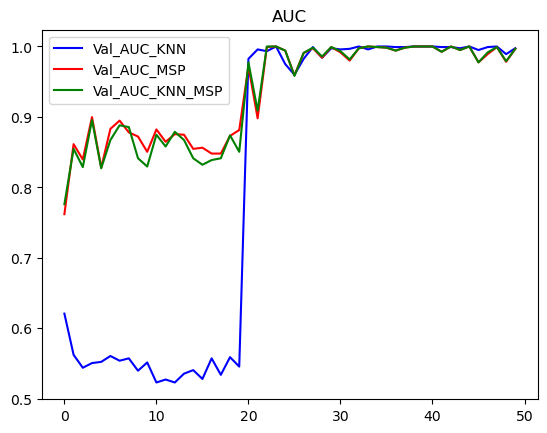

Max val_auces_knn:  1.0
Max val_auces:  1.0
Max val_auces_msp_knn:  1.0


In [17]:
args.data_type = 'grid'
args.epochs = 50
model, loss_fn, checkpoint_path, train_dataloader, train_dataloader_normal, test_dataloader, history = run_fit(args)

In [18]:
run_eval(model, loss_fn, checkpoint_path, train_dataloader_normal, test_dataloader)

=> loading checkpoint



Evaluating Standard ...
Val AUC:  1.0
Val ACC:  96.15384615384616
Val Loss:  0.0015665828608549559
Val AUC KNN:  1.0
MSP KNN AUC:  1.0
[0.9996264  0.99998677 0.99998486 0.99981457 0.99997973 0.99998987
 0.9995859  0.9999765  0.99999845 0.9999721  0.99975175 0.9999409
 0.99997854 0.9998709  0.99999964 0.9999949  0.99996376 0.99988353
 0.99998367 0.9999193  0.9999969  0.9998989  0.9999927  0.9998684
 0.05584512 0.99990916 0.9798147  0.98682225 0.9999403  0.992864
 0.9988041  0.999767   0.04630007 0.9999628  0.18286656 0.00105177
 0.00453575 0.04480392 0.0016803  0.00157069 0.00399635 0.00200128
 0.00193937 0.00154829 0.00421683 0.00258717 0.0030579  0.00190467
 0.00134109 0.00484119 0.00176551 0.00480939 0.00166083 0.01306824
 0.00188118 0.00238935 0.9999906  0.99998903 0.99999845 0.99997735
 0.9999846  0.9999608  0.99997497 0.99998903 0.99998784 0.99998116
 0.99997103 0.9999627  0.9999919  0.99989295 0.99973756 0.99996114
 0.999954   0.9997485  0.99998474 0.99883455 0.99976164 0.9997948

## Cable

In [19]:
args.data_type = 'cable'
args.epochs = 50
model, loss_fn, checkpoint_path, train_dataloader, train_dataloader_normal, test_dataloader, history = run_fit(args)

loading images


loaded 224 images
loading images
loaded 224 images
=> saving checkpoint: 0.4096 - acc: 80.7745

Epoch [1/50], loss: 0.0064 - auc: 0.8876 |
 val_loss: 0.0189 - best auc: 0.8218 - val_acc: 62.0000 - val_auc_msp: 0.8218 - val_auc_knn: 0.6475 - val_auc_knn_msp: 0.8190
Epoch [2/50], loss: 0.0049 - auc: 0.9341 |0
 val_loss: 0.0200 - best auc: 0.8218 - val_acc: 64.6667 - val_auc_msp: 0.7995 - val_auc_knn: 0.6496 - val_auc_knn_msp: 0.7879
Epoch [3/50], loss: 0.0046 - auc: 0.9375 |6
 val_loss: 0.0133 - best auc: 0.8218 - val_acc: 70.6667 - val_auc_msp: 0.7867 - val_auc_knn: 0.6477 - val_auc_knn_msp: 0.7837
=> saving checkpoint: 0.2834 - acc: 88.4511

Epoch [4/50], loss: 0.0044 - auc: 0.9452 |
 val_loss: 0.0161 - best auc: 0.8244 - val_acc: 68.6667 - val_auc_msp: 0.8244 - val_auc_knn: 0.6554 - val_auc_knn_msp: 0.8175
=> saving checkpoint: 0.2690 - acc: 89.4701

Epoch [5/50], loss: 0.0042 - auc: 0.9486 |
 val_loss: 0.0137 - best auc: 0.8385 - val_acc: 72.0000 - val_auc_msp: 0.8385 - val_auc_knn: 

In [ ]:
run_eval(model, loss_fn, checkpoint_path, train_dataloader_normal, test_dataloader)

## Zipper

In [ ]:
args.data_type = 'zipper'
args.epochs = 50
model, loss_fn, checkpoint_path, train_dataloader, train_dataloader_normal, test_dataloader, history = run_fit(args)

loading images
loaded 240 images
loading images
loaded 240 images
 Step: [31/46], loss: 0.4934 - acc: 74.9512

KeyboardInterrupt: 

In [ ]:
run_eval(model, loss_fn, checkpoint_path, train_dataloader_normal, test_dataloader)